# Lab One: Visualization and Data Preprocessing

**Group 4 Members:**
Megan Ball, Amber Clark, Matt Farrow, Blake Freeman

## 2015 Flight Delays and Cancellations
Data Source: [Kaggle](https://www.kaggle.com/usdot/flight-delays?select=flights.csv)

In [1]:
# Load libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Read flights data using Pandas
flights  = pd.read_csv('../Data/flights.csv')

/Users/mattfarrow/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Merge flights & airlines together
# source: https://www.kaggle.com/hakkisimsek/plotly-tutorial-2
airlines = pd.read_csv('../Data/airlines.csv')

df = pd.merge(flights, airlines, left_on = 'AIRLINE', right_on = 'IATA_CODE')
df.insert(loc = 5, column = 'AIRLINE', value = df.AIRLINE_y)
df = df.drop(['AIRLINE_y','IATA_CODE'], axis = 1)
df = df.rename(columns = {"AIRLINE_x":"AIRLINE_CODE"})

In [4]:
# Merge flights & airports together
# source: https://www.kaggle.com/hakkisimsek/plotly-tutorial-2
airports = pd.read_csv('../Data/airports.csv')

df = pd.merge(df, airports[['IATA_CODE','AIRPORT','CITY']], left_on = 'ORIGIN_AIRPORT', right_on = 'IATA_CODE')
df = df.drop(['IATA_CODE'], axis = 1)
df = df.rename(columns = {"ORIGIN_AIRPORT":"ORIGIN_AIRPORT_CODE", 
                          "AIRPORT_x":"ORIGIN_AIRPORT",
                          "CITY_x":"ORIGIN_CITY"})

df = pd.merge(df, airports[['IATA_CODE','AIRPORT','CITY']], left_on = 'DESTINATION_AIRPORT', right_on = 'IATA_CODE')
df = df.drop(['IATA_CODE'], axis = 1)
df = df.rename(columns = {"DESTINATION_AIRPORT":"DESTINATION_AIRPORT_CODE", 
                          "AIRPORT_y":"DESTINATION_AIRPORT",
                          "CITY_y":"DESTINATION_CITY"})

### Examine the Data

In [5]:
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE_CODE,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT_CODE,DESTINATION_AIRPORT_CODE,...,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,AIRPORT_x,CITY_x,DESTINATION_AIRPORT,DESTINATION_CITY
0,2015,1,1,4,AS,Alaska Airlines Inc.,98,N407AS,ANC,SEA,...,NaN,NaN,NaN,NaN,NaN,NaN,Ted Stevens Anchorage International Airport,Anchorage,Seattle-Tacoma International Airport,Seattle
1,2015,1,1,4,AS,Alaska Airlines Inc.,108,N309AS,ANC,SEA,...,NaN,NaN,NaN,NaN,NaN,NaN,Ted Stevens Anchorage International Airport,Anchorage,Seattle-Tacoma International Airport,Seattle
2,2015,1,1,4,AS,Alaska Airlines Inc.,136,N431AS,ANC,SEA,...,A,NaN,NaN,NaN,NaN,NaN,Ted Stevens Anchorage International Airport,Anchorage,Seattle-Tacoma International Airport,Seattle
3,2015,1,1,4,AS,Alaska Airlines Inc.,134,N464AS,ANC,SEA,...,NaN,NaN,NaN,NaN,NaN,NaN,Ted Stevens Anchorage International Airport,Anchorage,Seattle-Tacoma International Airport,Seattle
4,2015,1,1,4,AS,Alaska Airlines Inc.,114,N303AS,ANC,SEA,...,NaN,NaN,NaN,NaN,NaN,NaN,Ted Stevens Anchorage International Airport,Anchorage,Seattle-Tacoma International Airport,Seattle


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5332914 entries, 0 to 5332913
Data columns (total 36 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   YEAR                      int64  
 1   MONTH                     int64  
 2   DAY                       int64  
 3   DAY_OF_WEEK               int64  
 4   AIRLINE_CODE              object 
 5   AIRLINE                   object 
 6   FLIGHT_NUMBER             int64  
 7   TAIL_NUMBER               object 
 8   ORIGIN_AIRPORT_CODE       object 
 9   DESTINATION_AIRPORT_CODE  object 
 10  SCHEDULED_DEPARTURE       int64  
 11  DEPARTURE_TIME            float64
 12  DEPARTURE_DELAY           float64
 13  TAXI_OUT                  float64
 14  WHEELS_OFF                float64
 15  SCHEDULED_TIME            float64
 16  ELAPSED_TIME              float64
 17  AIR_TIME                  float64
 18  DISTANCE                  int64  
 19  WHEELS_ON                 float64
 20  TAXI_IN                 

In [7]:
df.describe()

,YEAR,MONTH,DAY,DAY_OF_WEEK,FLIGHT_NUMBER,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,...,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
count,5332914.0,5.332914e+06,5.332914e+06,5.332914e+06,5.332914e+06,5.332914e+06,5.249100e+06,5.249100e+06,5.246302e+06,5.246302e+06,...,5.332914e+06,5.242972e+06,5.231130e+06,5.332914e+06,5.332914e+06,1.003360e+06,1.003360e+06,1.003360e+06,1.003360e+06,1.003360e+06
mean,2015.0,6.207210e+00,1.568874e+01,3.919179e+00,2.178419e+03,1.330107e+03,1.336074e+03,9.774568e+00,1.610290e+01,1.357926e+03,...,1.493747e+03,1.475922e+03,4.885903e+00,2.691587e-03,1.639441e-02,1.348775e+01,7.768398e-02,1.890343e+01,2.368808e+01,2.980992e+00
std,0.0,3.383807e+00,8.774687e+00,1.993635e+00,1.760521e+03,4.843130e+02,4.974114e+02,3.759233e+01,8.991109e+00,4.990460e+02,...,5.079263e+02,5.279477e+02,3.978728e+01,5.181064e-02,1.269868e-01,2.807241e+01,2.180048e+00,4.787141e+01,4.332698e+01,2.062003e+01
min,2015.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-8.200000e+01,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,-8.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2015.0,3.000000e+00,8.000000e+00,2.000000e+00,7.310000e+02,9.170000e+02,9.210000e+02,-5.000000e+00,1.100000e+01,9.350000e+02,...,1.110000e+03,1.058000e+03,-1.300000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2015.0,6.000000e+00,1.600000e+01,4.000000e+00,1.690000e+03,1.325000e+03,1.331000e+03,-1.000000e+00,1.400000e+01,1.343000e+03,...,1.520000e+03,1.512000e+03,-5.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,0.000000e+00,2.000000e+00,4.000000e+00,0.000000e+00
75%,2015.0,9.000000e+00,2.300000e+01,6.000000e+00,3.252000e+03,1.730000e+03,1.741000e+03,8.000000e+00,1.900000e+01,1.755000e+03,...,1.919000e+03,1.917000e+03,8.000000e+00,0.000000e+00,0.000000e+00,1.800000e+01,0.000000e+00,1.900000e+01,3.000000e+01,0.000000e+00
max,2015.0,1.200000e+01,3.100000e+01,7.000000e+00,9.855000e+03,2.359000e+03,2.400000e+03,1.988000e+03,2.250000e+02,2.400000e+03,...,2.400000e+03,2.400000e+03,1.971000e+03,1.000000e+00,1.000000e+00,1.134000e+03,5.730000e+02,1.971000e+03,1.331000e+03,1.211000e+03


In [8]:
# How many missing values are there in the data?
# source: https://www.kaggle.com/hakkisimsek/plotly-tutorial-2
pd.concat([df.isnull().sum(), 100 * df.isnull().sum()/len(df)], 
              axis=1).rename(columns={0:'Missing Records', 1:'Percentage (%)'})

,Missing Records,Percentage (%)
YEAR,0,0.000000
MONTH,0,0.000000
DAY,0,0.000000
DAY_OF_WEEK,0,0.000000
AIRLINE_CODE,0,0.000000
AIRLINE,0,0.000000
FLIGHT_NUMBER,0,0.000000
TAIL_NUMBER,14367,0.269402
ORIGIN_AIRPORT_CODE,0,0.000000
DESTINATION_AIRPORT_CODE,0,0.000000


<AxesSubplot:>

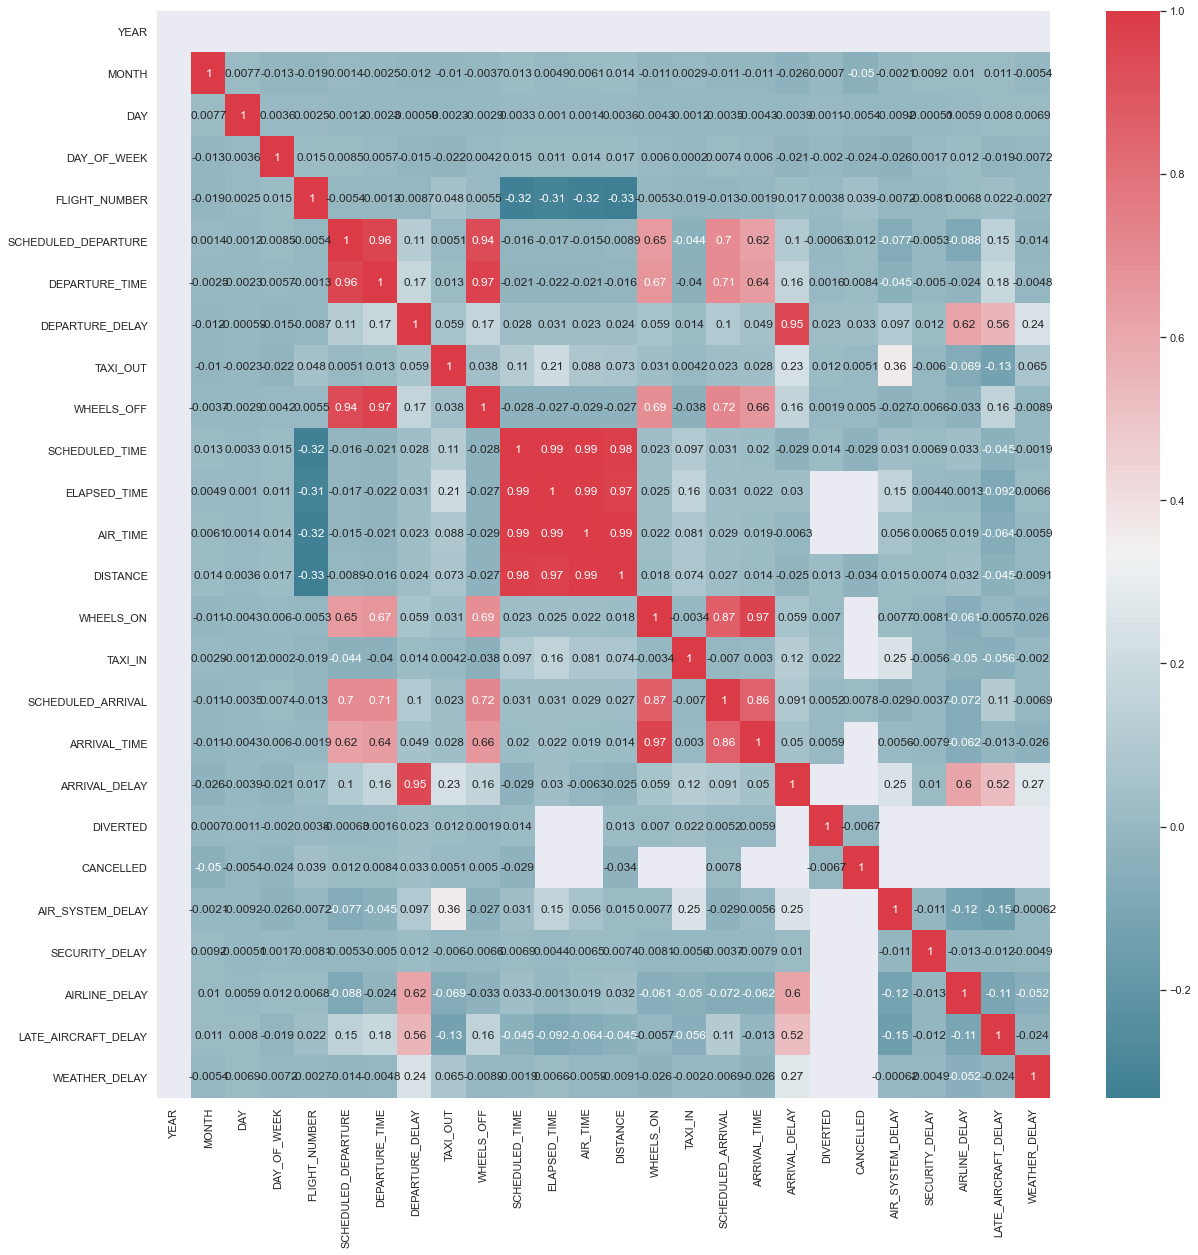

In [9]:
# Examine correlation visually using Seaborn. (Code adapted from 02. Data Visualization.ipynb)
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.set(style = "darkgrid") # one of the many styles to plot using

f, ax = plt.subplots(figsize = (20, 20))

sns.heatmap(df.corr(), cmap=cmap, annot = True)